This notebook contains steps and code to demonstrate Deep Learning model training and scoring in the Watson Machine Learning service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3 and <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook, you will learn how to:

-  Work with Watson Machine Learning experiments to train Deep Learning models (Tensorflow)
-  Save trained models in the Watson Machine Learning repository
-  Deploy a trained model online and score


## Contents

1.	[Set up](#setup)
2.	[Create the training definitions](#model)
3.  [Train the model](#train)
3.	[Save the model](#save)
4.	[Create the online deployment](#deploy)
5.	[Score data](#score)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up

The WML and COS were created automatically when you created this project. You can find them in IBM Cloud Dashboard https://console.bluemix.net

-  Find a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance is <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Find a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage is <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**
- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential+**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**. (For more information, see <a href="https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```

### 1.1 Work with Cloud Object Storage  (COS)

Install the boto library. This library allows Python developers to manage Cloud Object Storage (COS).

**Tip:** If `ibm_boto3` is not preinstalled in you environment, run the following command to install it: 

In [1]:
# Run the command if ibm_boto3 is not installed.
!pip install ibm-cos-sdk
!pip install wget

  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
# Install the boto library.
import ibm_boto3
from ibm_botocore.client import Config

1. Enter your COS credentials in the following cell. 

You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

**Note:** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

2. Authenticate to the Watson Machine Learning (WML) service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener noreferrer">Service credentials</a> tab of the service instance that you created on IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your COS and WML service instance credentials here (refer to the assignment slides for details).

In [29]:
cos_credentials = {
  "apikey": "IkY2kiEaHbTTaWTjM8aD6J19Ee9pb4KQB3n1IOTItdte",
  "cos_hmac_keys": {
    "access_key_id": "c9f2a5674c2c430e8c1b860b0ce0c1e9",
    "secret_access_key": "8e20cd9c0378d6a9dd5a72af5e9203d27cb0b044610b760a"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key c9f2a567-4c2c-430e-8c1b-860b0ce0c1e9",
  "iam_apikey_name": "Service credentials-2",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/0f3ab58ed8cd4ebcaf72030aa7595c7d::serviceid:ServiceId-037336c2-74ab-4e03-a144-9ac8ad8124e1",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/0f3ab58ed8cd4ebcaf72030aa7595c7d:b858da71-bf15-44f3-b752-864ea188c3e1::"
}

wml_credentials = {
  "apikey": "SvleaCKfKpFRtExEYUHQd2ImfBxTCe-dO7QephTRpMFo",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/0f3ab58ed8cd4ebcaf72030aa7595c7d:630c2069-5e1c-41e1-a79b-ee13b684e003::",
  "iam_apikey_name": "auto-generated-apikey-a9057e43-f32f-4324-9c85-84a7fd4a2045",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/0f3ab58ed8cd4ebcaf72030aa7595c7d::serviceid:ServiceId-a2f76480-d94c-4e04-b2af-30667df83165",
  "instance_id": "630c2069-5e1c-41e1-a79b-ee13b684e003",
  "password": "dbd2d753-972e-4633-81d2-d78b7d697f2c",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "a9057e43-f32f-4324-9c85-84a7fd4a2045"
}

Define the endpoint.

To do this, go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, then enter it in the cell below:

In [13]:
# Define endpoint information.
service_endpoint = 'https://s3.us.cloud-object-storage.appdomain.cloud'

You also need the IBM Cloud authorization endpoint to be able to create COS resource object. No need to change this.

In [14]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

Create a Boto resource to be able to write data to COS.

In [18]:
# Create a COS resource.
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [19]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-0059fa55-aeda-4f71-92ea-e381659125da"...
Creating bucket "training-results-0059fa55-aeda-4f71-92ea-e381659125da"...


Now you should have 2 buckets.

In [20]:
# Display a list of created buckets.
print(list(cos.buckets.all()))

[s3.Bucket(name='mscs621-donotdelete-pr-ms7vbm0flbo1su'), s3.Bucket(name='mscs6212019-donotdelete-pr-o6lfobehnlhtxw'), s3.Bucket(name='training-data-0059fa55-aeda-4f71-92ea-e381659125da'), s3.Bucket(name='training-data-6365d283-ef09-4609-8f08-676a3fd5af91'), s3.Bucket(name='training-data-7d821d81-0192-4f45-9720-cb41a0fc4b2a'), s3.Bucket(name='training-results-0059fa55-aeda-4f71-92ea-e381659125da'), s3.Bucket(name='training-results-6365d283-ef09-4609-8f08-676a3fd5af91'), s3.Bucket(name='training-results-7d821d81-0192-4f45-9720-cb41a0fc4b2a')]


### 1.2 Download the training data and upload it to the COS buckets

Download the training data and upload it to the 'training-data' bucket.
First, create a list of links for the training data set.

In [21]:
# Create a list of links.
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

The code in the next cell uploads files from links to your COS.

In [22]:
# Upload files from the links to COS
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Have a look at the list of the created buckets and their contents.

In [23]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

training-data-0059fa55-aeda-4f71-92ea-e381659125da
  File: t10k-images-idx3-ubyte.gz, 1610.23kB
  File: t10k-labels-idx1-ubyte.gz, 4.44kB
  File: train-images-idx3-ubyte.gz, 9680.10kB
  File: train-labels-idx1-ubyte.gz, 28.20kB
training-results-0059fa55-aeda-4f71-92ea-e381659125da


You are done with COS, and you are ready to train your model!

### 1.3. Work with the WML service instance

Import the libraries you need to work with your WML instance.

**Hint:** You may also need to install `wget` using the following command `!pip install wget`

In [24]:
import urllib3, requests, json, base64, time, os, wget

#### Install the `watson-machine-learning-client` library from pypi.

In [25]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [26]:
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.375)


#### Import the `watson-machine-learning-client` and authenticate to the service instance.

In [27]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

2019-10-13 23:53:30,798 - watson_machine_learning_client.wml_client_error - WARNING - Failure during training. (POST https://us-south.ml.cloud.ibm.com/v3/models)
Status code: 400, body: {
  "trace": "_",
  "errors": [{
    "code": "training_failed",
    "message": "Manifest Error: The supplied runtime name or version are not valid",
    "more_info": "http://watson-ml-api.mybluemix.net/"
  }]
}
2019-10-14 00:05:18,657 - watson_machine_learning_client.wml_client_error - WARNING - Failure during training. (POST https://us-south.ml.cloud.ibm.com/v3/models)
Status code: 400, body: {
  "trace": "_",
  "errors": [{
    "code": "training_failed",
    "message": "Manifest Error: The supplied runtime name or version are not valid",
    "more_info": "http://watson-ml-api.mybluemix.net/"
  }]
}
2019-10-14 00:09:53,649 - watson_machine_learning_client.wml_client_error - WARNING - Failure during training. (POST https://us-south.ml.cloud.ibm.com/v3/models)
Status code: 400, body: {
  "trace": "_",
  

**Note:** A deprecation warning is returned from scikit-learn package that does not impact watson machine learning client functionalities.

In [30]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [31]:
# Display the client version number.
print(client.version)

1.0.375


**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener noreferrer">here</a>.

<a id="model"></a>
## 2. Create the training definitions

In this section you:

- [2.1 Prepare the training definition metadata](#prep)
- [2.2 Get the sample model definition content files from Git](#get)
- [2.3 Store the training definition in the WML repository](#store)



### 2.1 Prepare the training definition metadata<a id="prep"></a>

In [44]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "My definition name",
            client.repository.DefinitionMetaNames.DESCRIPTION: "My description",
            client.repository.DefinitionMetaNames.AUTHOR_NAME: "John Smith",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.13",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.6",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20"
            }

### 2.2 Get the sample model definition content file from Git <a id="get"></a>
The model is in the marist-mscs621/unit-10-11/tf-softmax-model. You can check how it is implemented if interested.

In [33]:
filename='tf-softmax-model.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip')
    
print(filename)

tf-softmax-model.zip


### 2.3 Store the training definition in the WML repository<a id="store"></a>

In [45]:
definition_details = client.repository.store_definition(filename, model_definition_metadata)

In [46]:
definition_uid = client.repository.get_definition_uid(definition_details)

In [47]:
# Display the training definition uid.
print(definition_uid)

bdfa05c1-5026-4346-83d6-d01a3af09631


## 3. Train the model<a id="train"></a>

In this section, learn how to:
- [3.1 Enter training configuration metadata](#meta)
- [3.2 Train the model in the background](#backg)
- [3.3 Monitor the training log](#log)
- [3.4 Cancel the training run](#cancel)


### 3.1 Enter training configuration metadata<a id="meta"></a>

- `TRAINING_DATA_REFERENCE` - references the uploaded training data.
- `TRAINING_RESULTS_REFERENCE` - location where trained model will be saved.

**Note** Your COS credentials are referenced in this code.


In [48]:
# Configure the training metadata for the TRAINING_DATA_REFERENCE and TRAINING_RESULTS_REFERENCE.
training_configuration_metadata = {
            client.training.ConfigurationMetaNames.NAME: "Hand-written Digit Recognition", 
            client.training.ConfigurationMetaNames.AUTHOR_NAME: "John Smith",              
            client.training.ConfigurationMetaNames.DESCRIPTION: "Hand-written Digit Recognition training",
            client.training.ConfigurationMetaNames.COMPUTE_CONFIGURATION: {"name": "k80"},
            client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
                    "connection": {
                        "endpoint_url": service_endpoint,
                        "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                        "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                    },
                    "source": {
                        "bucket": buckets[0],
                    },
                    "type": "s3"
                },
            client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
                "connection": {
                    "endpoint_url": service_endpoint,
                    "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                    "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                },
                "target": {
                    "bucket": buckets[1],
                },
                "type": "s3"
            },
        }

### 3.2 Train the model in the background<a id="backg"></a>

To run the training in the **background**, set the optional parameter `asynchronous=True` (or remove it). In this case the parameter has been removed. 

**Note:** To run the training in **active** mode, set `asynchronous=False`.

In [49]:
training_run_details = client.training.run(definition_uid, training_configuration_metadata)

In [50]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

Check the status of the training run by calling the method the next cell:

In [53]:
# Get training run status.
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "state": "completed",
  "finished_at": "2019-10-14T00:16:46.197Z",
  "submitted_at": "2019-10-14T00:13:59.687Z",
  "running_at": "2019-10-14T00:14:16.939Z",
  "message": "training-rNPix4TWg: ",
  "metrics": [],
  "current_at": "2019-10-14T00:17:13.099Z"
}


### 3.3  Monitor the training log<a id="log"></a>

Run the cell below to monitor the training log.

In [54]:
client.training.monitor_logs(training_run_guid_async)



####################################################

Log monitor started for training run: model-pisir7xk

####################################################


Training with training/test data at:
  DATA_DIR: /mnt/data/training-data-0059fa55-aeda-4f71-92ea-e381659125da
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: python3 tensorflow_mnist_softmax.py --trainingIters 20
Storing trained model at:
  RESULT_DIR: /mnt/results/training-results-0059fa55-aeda-4f71-92ea-e381659125da/training-rNPix4TWg
Mon Oct 14 00:14:34 UTC 2019: Running Tensorflow job
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions

### 3.4 Cancel the training run<a id="cancel"></a>

You can cancel the training run by calling the method below.

<a id="save"></a>
## 4. Save the model

#### Call this method to the save model to the WML repository.

In [55]:
# Save model to WML repository.
saved_model_details = client.repository.store_model(training_run_guid_async, {"name": "My cool mnist model"})

In [56]:
# Display location of saved model.
print("Url: " + client.repository.get_model_url(saved_model_details))

Url: https://us-south.ml.cloud.ibm.com/v3/wml_instances/630c2069-5e1c-41e1-a79b-ee13b684e003/published_models/7c01a133-675d-41e3-9501-67560084f116


**Tip:** Run the code below to extract the stored model uid from the dictionary.

In [57]:
# Get and display model uid.
model_uid = client.repository.get_model_uid(saved_model_details)
print("Saved model uid: " + model_uid)

Saved model uid: 7c01a133-675d-41e3-9501-67560084f116


#### List the stored models.

In [58]:
client.repository.list_models()

------------------------------------  -------------------  ------------------------  ---------------
GUID                                  NAME                 CREATED                   FRAMEWORK
7c01a133-675d-41e3-9501-67560084f116  My cool mnist model  2019-10-14T00:36:09.750Z  tensorflow-1.13
b60bbfa7-0682-400d-9c7d-ea2d8fc3e242  My cool mnist model  2018-11-02T19:28:41.269Z  tensorflow-1.5
------------------------------------  -------------------  ------------------------  ---------------


#### Delete the training run and its results.

Run the code in the cell below to delete train runs and results:

## 5. Create the online deployment<a id="deploy"></a>

Run the code in the following cell to deploy the stored model as a web service (online):

In [59]:
# Create online deployment.
deployment_details = client.deployments.create(model_uid, "Mnist model deployment")



#######################################################################################

Synchronous deployment creation for uid: '7c01a133-675d-41e3-9501-67560084f116' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='cdf01804-051c-4683-8bea-4b732c3c08e2'
------------------------------------------------------------------------------------------------




## 6. Score data<a id="score"></a>

Now, extract the url endpoint, scoring_url, which will be used to send scoring requests.

In [60]:
#  Extract endpoint url and display it.
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/630c2069-5e1c-41e1-a79b-ee13b684e003/deployments/cdf01804-051c-4683-8bea-4b732c3c08e2/online


Prepare sample scoring data to score deployed model.

In [61]:
image0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,51, 159, 253, 159,50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,48, 238, 252, 252, 252, 237, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,54, 227, 253, 252, 239, 233, 252,57, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,10,60, 224, 252, 253, 252, 202,84, 252, 253, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 252, 252, 252, 253, 252, 252,96, 189, 253, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,51, 238, 253, 253, 190, 114, 253, 228,47,79, 255, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,48, 238, 252, 252, 179,12,75, 121,21, 0, 0, 253, 243,50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,38, 165, 253, 233, 208,84, 0, 0, 0, 0, 0, 0, 253, 252, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 178, 252, 240,71,19,28, 0, 0, 0, 0, 0, 0, 253, 252, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,57, 252, 252,63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 253, 252, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 253, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 253, 196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,76, 246, 252, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 253, 252, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,85, 252, 230,25, 0, 0, 0, 0, 0, 0, 0, 0, 7, 135, 253, 186,12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,85, 252, 223, 0, 0, 0, 0, 0, 0, 0, 0, 7, 131, 252, 225,71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,85, 252, 145, 0, 0, 0, 0, 0, 0, 0,48, 165, 252, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,86, 253, 225, 0, 0, 0, 0, 0, 0, 114, 238, 253, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,85, 252, 249, 146,48,29,85, 178, 225, 253, 223, 167,56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,85, 252, 252, 252, 229, 215, 252, 252, 252, 196, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,28, 199, 252, 252, 253, 252, 252, 233, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,25, 128, 252, 253, 252, 141,37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 253, 255,63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,96, 244, 251, 253,62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 251, 251, 253,62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,68, 236, 251, 211,31, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,60, 228, 251, 251,94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 253, 253, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,20, 253, 251, 235,66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,32, 205, 253, 251, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 104, 251, 253, 184,15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,80, 240, 251, 193,23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,32, 253, 253, 253, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 251, 251, 251,39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,48, 221, 251, 251, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 234, 251, 251, 196,12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 253, 251, 251,89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 255, 253, 253,31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,48, 228, 253, 247, 140, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,64, 251, 253, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,64, 251, 253, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,24, 193, 253, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,13,25, 100, 122, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,33, 151, 208, 252, 252, 252, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,40, 152, 244, 252, 253, 224, 211, 252, 232,40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,15, 152, 239, 252, 252, 252, 216,31,37, 252, 252,60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,96, 252, 252, 252, 252, 217,29, 0,37, 252, 252,60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 252, 252, 220, 167,30, 0, 0,77, 252, 252,60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,26, 128,58,22, 0, 0, 0, 0, 100, 252, 252,60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 252, 252,60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 121, 122, 121, 202, 252, 194, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,10,53, 179, 253, 253, 255, 253, 253, 228,35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,54, 227, 252, 243, 228, 170, 242, 252, 252, 231, 117, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,78, 252, 252, 125,59, 0,18, 208, 252, 252, 252, 252,87, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 135, 252, 252, 180,16, 0,21, 203, 253, 247, 129, 173, 252, 252, 184,66,49,49, 0, 0, 0, 0, 0, 0, 0, 0, 3, 136, 252, 241, 106,17, 0,53, 200, 252, 216,65, 0,14,72, 163, 241, 252, 252, 223, 0, 0, 0, 0, 0, 0, 0, 0, 105, 252, 242,88,18,73, 170, 244, 252, 126,29, 0, 0, 0, 0, 0,89, 180, 180,37, 0, 0, 0, 0, 0, 0, 0, 0, 231, 252, 245, 205, 216, 252, 252, 252, 124, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 207, 252, 252, 252, 252, 178, 116,36, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,13,93, 143, 121,23, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,38,43, 105, 255, 253, 253, 253, 253, 253, 174, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,43, 139, 224, 226, 252, 253, 252, 252, 252, 252, 252, 252, 158,14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 252, 252, 252, 252, 253, 252, 252, 252, 252, 252, 252, 252,59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 252, 252, 230, 132, 133, 132, 132, 189, 252, 252, 252, 252,59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,29,29,24, 0, 0, 0, 0,14, 226, 252, 252, 172, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,85, 243, 252, 252, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,88, 189, 252, 252, 252,14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,91, 212, 247, 252, 252, 252, 204, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,32, 125, 193, 193, 193, 253, 252, 252, 252, 238, 102,28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,45, 222, 252, 252, 252, 252, 253, 252, 252, 252, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,45, 223, 253, 253, 253, 253, 255, 253, 253, 253, 253,74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,31, 123,52,44,44,44,44, 143, 252, 252,74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,15, 252, 252,74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,86, 252, 252,74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,75, 9, 0, 0, 0, 0, 0, 0,98, 242, 252, 252,74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,61, 183, 252,29, 0, 0, 0, 0,18,92, 239, 252, 252, 243,65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 208, 252, 252, 147, 134, 134, 134, 134, 203, 253, 252, 252, 188,83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 208, 252, 252, 252, 252, 252, 252, 252, 252, 253, 230, 153, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,49, 157, 252, 252, 252, 252, 252, 217, 207, 146,45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 103, 235, 252, 172, 103,24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image4 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,67, 232,39, 0, 0, 0, 0, 0, 0, 0, 0, 0,62,81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 180,39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 153, 210,40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 220, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,27, 254, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 222, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 254, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0,46, 245, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 254,56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 254, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,23, 231, 254,29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 254, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 254, 216,16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 254,67, 0, 0, 0, 0, 0, 0, 0, 0, 0,14,86, 178, 248, 254,91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 254,85, 0, 0, 0,47,49, 116, 144, 150, 241, 243, 234, 179, 241, 252,40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 253, 237, 207, 207, 207, 253, 254, 250, 240, 198, 143,91,28, 5, 233, 250, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 177, 177, 177, 177, 177,98,56, 0, 0, 0, 0, 0, 102, 254, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 254, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 254,57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 254,57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 255,94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 254,96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 254, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 255, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,96, 254, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image5 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,18,18,18, 126, 136, 175,26, 166, 255, 247, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,30,36,94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195,64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251,93,82,82,56,39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,80, 156, 107, 253, 253, 205,11, 0,43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,14, 1, 154, 253,90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 253, 190, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,11, 190, 253,70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,35, 241, 225, 160, 108, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,81, 240, 253, 253, 119,25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,45, 186, 253, 253, 150,27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,16,93, 252, 253, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 249, 253, 249,64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,46, 130, 183, 253, 253, 207, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,39, 148, 229, 253, 253, 253, 250, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,24, 114, 221, 253, 253, 253, 253, 201,78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,23,66, 213, 253, 253, 253, 253, 198,81, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,18, 171, 219, 253, 253, 253, 253, 195,80, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,55, 172, 226, 253, 253, 253, 253, 244, 133,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 253, 253, 253, 212, 135, 132,16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image6 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,38, 222, 225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 234, 252, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,23, 197, 253, 252, 208,19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,38, 178, 252, 253, 117,65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,57, 252, 252, 253,89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,38, 222, 253, 253,79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 252, 179,27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 246, 220,37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,79, 253, 252, 135,28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,16, 140, 253, 252, 118, 0, 0, 0, 0, 111, 140, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,13, 191, 255, 253,56, 0, 0, 114, 113, 222, 253, 253, 255,27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,76, 252, 253, 223,37, 0,48, 174, 252, 252, 242, 214, 253, 199,31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,13, 109, 252, 228, 130, 0,38, 165, 253, 233, 164,49,63, 253, 214,31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,73, 252, 252, 126, 0,23, 178, 252, 240, 148, 7,44, 215, 240, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 252, 252, 0, 0, 197, 252, 252,63, 0,57, 252, 252, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 253, 174, 0,48, 229, 253, 112, 0,38, 222, 253, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 252, 173, 0,48, 227, 252, 158, 226, 234, 201,27,12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,57, 252, 252,57, 104, 240, 252, 252, 253, 233,74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,51, 242, 252, 253, 252, 252, 252, 252, 240, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,75, 189, 253, 252, 252, 157, 112,63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image7 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 121, 162, 253, 253, 213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,63, 107, 170, 251, 252, 252, 252, 252, 250, 214, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,25, 192, 226, 226, 241, 252, 253, 202, 252, 252, 252, 252, 252, 225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,68, 223, 252, 252, 252, 252, 252,39,19,39,65, 224, 252, 252, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 252, 252, 252, 245, 108,53, 0, 0, 0, 150, 252, 252, 220,20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,70, 242, 252, 252, 222,59, 0, 0, 0, 0, 0, 178, 252, 252, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 252, 252, 194,67, 0, 0, 0, 0,17,90, 240, 252, 194,67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,83, 205, 190,24, 0, 0, 0, 0, 0, 121, 252, 252, 209,24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,77, 247, 252, 248, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 253, 252, 252, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 255, 253, 253,39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 183, 253, 252, 107, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,10, 102, 252, 253, 163,16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,13, 168, 252, 252, 110, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,41, 252, 252, 217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,40, 155, 252, 214,31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 252, 252, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,43, 179, 252, 150,39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 252, 221,39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,67, 252,79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,11, 203, 229,32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,26,47,47,30,95, 254, 215,13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,45, 154, 185, 185, 223, 253, 253, 133, 175, 255, 188,19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 253, 253, 253, 246, 161, 228, 253, 253, 254,92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 245, 253, 158, 137,21, 0,48, 233, 253, 233, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 254, 223,25, 0, 0,36, 170, 254, 244, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,55, 212, 253, 161,11,26, 178, 253, 236, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 155, 253, 228,80, 223, 253, 253, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 253, 253, 253, 254, 253, 154,29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 253, 253, 253, 254, 179,38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 171, 254, 254, 254, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 253, 253, 253, 253, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,26, 123, 254, 253, 203, 156, 253, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,93, 253, 254, 121,13,93, 253, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,64, 239, 253,76, 8,32, 219, 253, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 254, 191, 0, 5, 108, 234, 254, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 253, 190, 5,85, 253, 236, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 253, 169, 192, 253, 253,77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 253, 253, 254, 236, 129, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,17, 118, 243, 191, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
image9 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,55, 148, 210, 253, 253, 113,87, 148,55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,87, 232, 252, 253, 189, 210, 252, 252, 253, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,57, 242, 252, 190,65, 5,12, 182, 252, 253, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,96, 252, 252, 183,14, 0, 0,92, 252, 252, 225,21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 253, 252, 146,14, 0, 0, 0, 215, 252, 252,79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 253, 247, 176, 9, 0, 0, 8,78, 245, 253, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,16, 232, 252, 176, 0, 0, 0,36, 201, 252, 252, 169,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,22, 252, 252,30,22, 119, 197, 241, 253, 252, 251,77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,16, 231, 252, 253, 252, 252, 252, 226, 227, 252, 231, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,55, 235, 253, 217, 138,42,24, 192, 252, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,62, 255, 253, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,71, 253, 252,21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 253, 252,21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,71, 253, 252,21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 106, 253, 252,21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,45, 255, 253,21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 218, 252,56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,96, 252, 189,42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,14, 184, 252, 170,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,14, 147, 252,42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

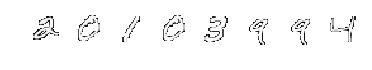

In [63]:
MY_CWID = [image2, image0, image1, image0, image3, image9, image9, image4]
for i, image in enumerate(MY_CWID):
    plt.subplot(1, 8, i + 1)
    plt.axis('off')
    plt.imshow( (np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

Build a scoring dictionary consisting of two digits and send it to the deployed model to get predictions.

In [64]:
# Build scoring dictionary which has two digits (image1 and image29.
scoring_data = {'values': MY_CWID}

In [65]:
# send scoring dictionary to deployed model to get predictions
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'values': [2, 0, 1, 0, 3, 9, 9, 4]}


<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use `watson-machine-learning-client` to train and score TensorFlow models. 
 
Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for a <a href="https://dataplatform.ibm.com/docs/content/analyze-data/ml-python-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">tutorial</a> and more samples, documentation, how-tos, and blog posts. 

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.